In [101]:
import numpy as np
import random
import pandas as pd
from keras.models import Model
from keras.layers import Input,Dense,LSTM,Conv1D,Activation
from keras import optimizers
import keras

In [105]:
def input_vectors(time_series):
    splitted_data = []
    for i in range (0,time_series.shape[0] // 14 - 1):
        chunk = time_series[i*14:(i+1)*14]
        splitted_data.append(chunk.reshape(1,14,1))
    return np.vstack(splitted_data)
def prep_data(file_name):
    days_data = []
    with open(file_name) as f:
        for i, line in enumerate(f):
            if i:
                sequence =  float(line.rstrip().split(',')[-1])
                days_data.append(sequence)
    days_data = np.array(days_data[::-1])
    print(days_data.max())
    days_data -= days_data.min()
    days_data /= days_data.max()
    number_of_days = days_data.shape[0]
    n = number_of_days
    training = days_data[:-int(0.2*n)]
    testing = days_data[-int(0.2*n):]
    training_d = training[:-1]
    training_l = training[1:]
    testing_d = testing[:-1]
    testing_l = testing[1:]
    print(len(days_data))
    return input_vectors(training_d),input_vectors(training_l),input_vectors(testing_d), input_vectors(testing_l)

def reshaper(v):
    l = v.shape[0]
    return v.reshape(l, 1)

def subsample(l, y, n=1):
    start = random.randint(0, l.shape[0]- (n+1))
    subsample = l[start:start+n]
    suby = y[start: start+n]
    init = np.zeros((len(l) - n, 1))
    return np.concatenate([init, subsample], axis=0), np.concatenate([init, suby], axis=0)

In [106]:
def lstm():
    inp = Input(shape=(14, 1))
    x = LSTM(32, return_sequences=True)(inp)
    x = Dense(1, activation='relu')(x)
    return Model(inputs=inp, outputs=x)
def augment(xs, ys, times=5):
    d, ts, f = xs.shape
    aug_xs = []
    aug_ys = []
    for i in range(d):
        for j in range(times-1):
            random.seed(12)
            q = random.randint(0, ts - 1)
            ax, ay = subsample(xs[i], ys[i], n=q)
            aug_xs.append(ax.reshape(1, ts, f))
            aug_ys.append(ay.reshape(1, ts, f))
    aug_xs = np.vstack(aug_xs)
    aug_ys = np.vstack(aug_ys)
    xs = np.concatenate([xs, aug_xs], axis=0)
    ys = np.concatenate([ys, aug_ys], axis=0)
    return xs, ys

In [107]:
if __name__ == '__main__':
    trd, trl, ted, tel = prep_data('minutedata.csv')
    
    trd, trl = augment(trd, trl, times=10)
    ted, tel = augment(ted, tel, times=10)

    np.save('trd.npy', trd)
    np.save('trl.npy', trl)
    np.save('ted.npy', ted)
    np.save('tel.npy', tel)
    
    epochs = 50
    lr = 1e-3
    decay = lr / epochs
    adam = keras.optimizers.Adam(lr=lr, decay=decay)
    adagrad = keras.optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0) 
    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    rms = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    model = lstm()

    model.summary()
    model.compile(loss='mse', optimizer=sgd, metrics=['mse'])
    history=model.fit(trd, trl, batch_size=14, epochs=epochs, validation_data=[ted, tel], shuffle=True)

51800.0
30353
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 14, 1)             0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 14, 32)            4352      
_________________________________________________________________
dense_19 (Dense)             (None, 14, 1)             33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Train on 17330 samples, validate on 4320 samples
Epoch 1/10
17330/17330 [==============================] - 14s 804us/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 2/10
17330/17330 [==============================] - 11s 632us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epo

In [53]:
loss = history.history['loss']
loss_df = pd.DataFrame(loss)
loss_df.to_csv('lossadagrad.csv', index=False)

In [17]:
history.history

{'loss': [0.0049758758149298123,
  0.0021666222811048998,
  0.0021294046726110004,
  0.0021074350146374041,
  0.0020895182331175633,
  0.0020736170488477074,
  0.0020629398829893784,
  0.0020544697971548198,
  0.0020517226924336792,
  0.0020479749743042494,
  0.002045052046330187,
  0.0020465326866413351,
  0.0020425802204755475,
  0.002040086809410699,
  0.0020378281022465092,
  0.0020355404601737361,
  0.0020345939046472008,
  0.0020306205408005223,
  0.0020307053443098183,
  0.0020254126523648595,
  0.0020237815908005444,
  0.0020219440787817636,
  0.002019335565279108,
  0.0020161843662938948,
  0.0020149402638580073,
  0.0020120247181633789,
  0.0020067576543347878,
  0.002006754382859779,
  0.002001642852833102,
  0.0019984543269558042,
  0.0019937737855225241,
  0.0019899508079335273,
  0.0019872758396455832,
  0.0019827952367044376,
  0.0019784075152057832,
  0.0019771958350280126,
  0.0019743775891667382,
  0.0019706198921275665,
  0.0019708997447917018,
  0.001966694167668130

In [54]:
mse = history.history['mean_squared_error']
mse_df = pd.DataFrame(mse)
mse_df.to_csv('mseadagrad.csv', index=False)

In [55]:
val_mse = history.history['val_mean_squared_error']
val_mse_df = pd.DataFrame(val_mse)
val_mse_df.to_csv('valadafrad.csv', index=False)

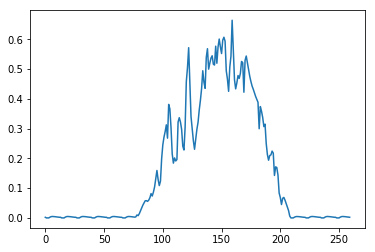

In [93]:
y=model.predict_on_batch(ted)
y.shape
ted.shape
prediction = []
ground_truth = []
for i in range (62,82):
    for j in range (0,13):
        prediction.append(y[i][j][0])
        ground_truth.append(ted[i][j][0])
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(prediction)

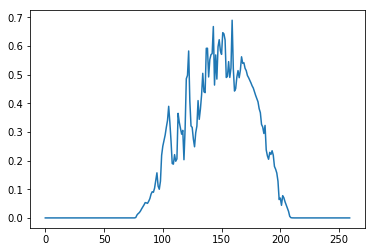

In [88]:
plt.plot(ground_truth)

In [94]:
prediction = pd.DataFrame(prediction)
prediction.to_csv('predictionsgd.csv' , index=False)
ground_truth_df = pd.DataFrame(ground_truth)
ground_truth_df.to_csv('ground_truth.csv', index=False)